# Demo: The Unscented Particle Filter

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

/Users/jhamrick/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## True model

In [2]:
def transition_func(x, t, omega=4*np.e-2, phi=0.5):
    return 1 + np.sin(omega * np.pi * t) + phi * x

def transition(x, t, omega=4*np.e-2, phi=0.5):
    vt = scipy.stats.gamma.rvs(3, scale=1/2)
    return transition_func(x, t, omega=omega, phi=phi) + vt

def transition_density(xnew, xold, t, omega=4*np.e-2, phi=0.5):
    xest = transition_func(xold, t, omega=omega, phi=phi)
    return scipy.stats.gamma.logpdf(xnew - xest, 3, scale=1/2)

def observation_func(x, t, phi1=0.2, phi2=0.5):
    if t <= 30:
        return phi1 * x ** 2
    else:
        return phi2 * x - 2
    
def observation(x, t, phi1=0.2, phi2=0.5):
    nt = scipy.stats.norm.rvs(loc=0, scale=np.sqrt(1e-5))
    return observation_func(x, t, phi1=phi1, phi2=phi2) + nt
    
def observation_density(y, x, t, phi1=0.2, phi2=0.5):
    yest = observation_func(x, t, phi1=phi1, phi2=phi2)
    return scipy.stats.norm.logpdf(y - yest, loc=0, scale=np.sqrt(1e-5))

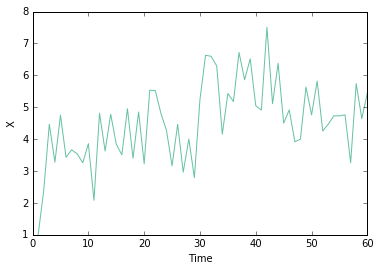

In [3]:
Xorig = np.empty(60)
Xorig[0] = 1
Yorig = np.empty(60)
Yorig[0] = observation(Xorig[0], 0)

for t in range(1, 60):
    Xorig[t] = transition(Xorig[t-1], t + 1)
    Yorig[t] = observation(Xorig[t], t + 1)

plt.plot(np.arange(60) + 1, Xorig, '-')
plt.xlabel('Time')
plt.ylabel('X')

## Regular particle filter

In [4]:
def particle_filter(Y, N=200):
    # initialization
    X = np.empty((len(Y) + 1, N))
    w = np.ones((len(Y) + 1, N)) / N
    for i in range(N):
        X[0, i] = np.random.randn() + 1
        
    for t in range(len(Y)):
        # propagate particles and calculate unnormalized weights
        Xtilde = np.empty(N)
        wtilde = np.empty(N)
        for i in range(N):
            Xtilde[i] = transition(X[t, i], t + 1)
            wtilde[i] = observation_density(Y[t], Xtilde[i], t + 1)
            
        # normalize weights
        w[t + 1] = np.exp(wtilde - scipy.misc.logsumexp(wtilde))
        w[t + 1] /= np.sum(w[t + 1])
        
        # resample particles
        X[t + 1] = Xtilde[np.random.choice(np.arange(N), size=N, p=w[t + 1])]
        
        # MCMC step
        for i in range(N):
            u = np.random.rand()
            x = transition(X[t, i], t)
            p_x = np.exp(observation_density(Y[t], x, t + 1))
            p_xtilde = np.exp(observation_density(Y[t], X[t + 1, i], t + 1))
            if u <= min(1, p_x / p_xtilde):
                X[t + 1, i] = x
                
    return X, w

In [5]:
particles = particle_filter(Yorig)
Xest = particles[0][1:].mean(axis=1)

/Users/jhamrick/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in double_scalars
/Users/jhamrick/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in double_scalars


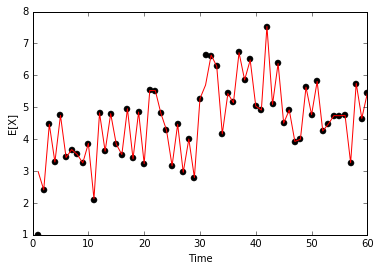

In [6]:
plt.plot(np.arange(60) + 1, Xorig, 'ko')
plt.plot(np.arange(60) + 1, Xest, 'r-')
plt.xlabel('Time')
plt.ylabel('E[X]')

## Unscented particle filter

In [7]:
def calc_sigma_weights(n=1, alpha=1, kappa=2, beta=0):
    lam = alpha ** 2 * (n + kappa) - n
    Wm = np.empty(2 * n + 1)
    Wc = np.empty(2 * n + 1)
    Wm[0] = lam / (n + lam)
    Wc[0] = (lam / (n + lam)) + (1 - alpha ** 2 + beta)
    for i in range(1, 2 * n + 1):
        Wm[i] = 1 / (2 * (n + lam))
        Wc[i] = 1 / (2 * (n + lam))
    return Wm, Wc

In [8]:
def calc_sigma_points(X, P, n=1, alpha=1, kappa=2):
    lam = alpha ** 2 * (n + kappa) - n
    sigma = np.zeros(2 * n + 1)
    sigma[0] = X.copy()
    for i in range(1, n + 1):
        sigma[i] = X + np.sqrt((n + lam) * P)
        sigma[i + n] = X - np.sqrt((n + lam) * P)
    return sigma    

In [9]:
def unscented_update(Xm_old, P_old, Y_obs, t, n=1):
    # calculate sigma points and weights
    Wm, Wc = calc_sigma_weights()
    sigma = calc_sigma_points(Xm_old, P_old, n=n)

    # propagate sigma points
    X = np.zeros(2 * n + 1)
    Y = np.zeros(2 * n + 1)
    for i in range(2 * n + 1):
        X[i] = transition(sigma[i], t)
        Y[i] = observation(X[i], t)

    # compute conditional t|t-1 distributions
    Xm_cond = np.sum(Wm * X)
    P_cond = np.sum(Wc * (X - Xm_cond) ** 2)
    Ym_cond = np.sum(Wm * Y)

    # incorporate new observation
    Pyy = np.sum(Wc * (Y - Ym_cond) ** 2)
    Pxy = np.sum(Wc * (Y - Ym_cond) * (X - Xm_cond))
    K = Pxy / Pyy
    Xm_new = Xm_cond + K * (Y_obs - Ym_cond)
    P_new = P_cond - (K * Pyy * K)
    
    assert P_new >= 0

    return Xm_new, P_new

In [10]:
def propagate(Xm, P, N):
    Xtilde = np.zeros(N)
    for i in range(N):
        Xtilde[i] = np.random.normal(Xm[i], np.sqrt(P[i]))
    return Xtilde

In [11]:
def calc_weights(Xtilde, X, Y, Xm, P, t, N):
    # calculate unnormalized weights
    wtilde = np.zeros(N)
    for i in range(N):
        p_Xtilde = scipy.stats.norm.logpdf(Xtilde[i], loc=Xm[i], scale=np.sqrt(P[i]))
        p_obs = observation_density(Y, Xtilde[i], t)
        p_trans = transition_density(Xtilde[i], X[i], t)
        wtilde[i] = p_obs + p_trans - p_Xtilde

    # normalize weights
    ix = ~(np.isnan(wtilde) | np.isinf(wtilde))
    w = np.zeros(N)
    w[ix] = np.exp(wtilde[ix] - scipy.misc.logsumexp(wtilde[ix]))
    w /= np.sum(w)
    
    return w

In [12]:
def unscented_particle_filter(Y, N=200, alpha=1, beta=0, kappa=2):
    # PF initialization
    Y = np.concatenate([[0], Y])
    X = np.zeros((len(Y), N))
    w = np.ones((len(Y), N)) / N
    for i in range(N):
        X[0, i] = np.random.randn() + 1

    # UKF initialization
    Xm = np.zeros((len(Y), N))
    Xm[0, :] = X[0].copy()
    P = np.zeros((len(Y), N))
    P[0, :] = 1

    for t in range(1, len(Y)):
        for i in range(N):
            # perform kalman update
            Xm[t, i], P[t, i] = unscented_update(Xm[t - 1, i], P[t - 1, i], Y[t], t)

        # propagate particles and calculate weights
        Xtilde = propagate(Xm[t], P[t], N)
        wtilde = calc_weights(Xtilde, X[t - 1], Y[t - 1], Xm[t], P[t], t, N)

        # resample particles
        idx = np.random.choice(np.arange(N), size=N, p=wtilde)
        X[t] = Xtilde[idx]
        w[t] = wtilde[idx]
        Xm[t] = Xm[t, idx]
        P[t] = P[t, idx]

        # MCMC step
        for i in range(N):
            u = np.random.rand()
            x = transition(X[t - 1, i], t)
            p_x = np.exp(observation_density(Y[t], x, t))
            p_xtilde = np.exp(observation_density(Y[t], X[t, i], t))
            if u <= min(1, p_x / p_xtilde):
                X[t, i] = x
                Xm[t, i] = x
                P[t, i] = 1

    return X, w, Xm, P

In [13]:
unscented_particles = unscented_particle_filter(Yorig)
unscented_Xest = unscented_particles[0][1:].mean(axis=1)

/Users/jhamrick/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in double_scalars
/Users/jhamrick/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: RuntimeWarning: divide by zero encountered in double_scalars


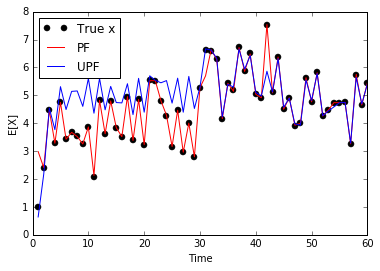

In [14]:
fig, ax = plt.subplots()
ax.plot(np.arange(60) + 1, Xorig, 'ko', label='True x')
ax.plot(np.arange(60) + 1, Xest, 'r-', label='PF')
ax.plot(np.arange(60) + 1, unscented_Xest, 'b-', label='UPF')
ax.set_xlabel('Time')
ax.set_ylabel('E[X]')
ax.legend(loc='best')